### Re-visit the OpenSoundScape CNN model training process. 


- So far we've built a training dataset containing human tags of the target species, and inferrred a set of negative samples. 
- These samples still need some human verification to remove mis-labelled samples. 
- This notebook attempts to use OpenSoundScape's methods for training.

In [1]:
# !pip install wandb
# ! pip install wandb --upgrade

In [2]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [3]:
# autoreload
%load_ext autoreload
%autoreload 2

In [4]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [5]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [6]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols, show_sample_from_df
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import torch
model_save_path = BASE_PATH / 'models'

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
# load the raw data
data_path = Path.cwd().parent.parent / "data"
train_df_path = Path.cwd().parent.parent / "data" / "interim" / "train_and_valid_set"
df_train = pd.read_pickle(train_df_path / "train_and_valid_set.pkl")

In [8]:
df_train.sample()

<bound method NDFrame.sample of         Unnamed: 0 organization                          project  project_id  \
1             1752           BU   Amplitude Quality Testing 2020         293   
2             1758           BU   Amplitude Quality Testing 2020         293   
3             1761           BU   Amplitude Quality Testing 2020         293   
4             1764           BU   Amplitude Quality Testing 2020         293   
5             1767           BU   Amplitude Quality Testing 2020         293   
...            ...          ...                              ...         ...   
539725     2365391           BU  Zeller Woodpeckers- Time of Day        1241   
539726     2365395           BU  Zeller Woodpeckers- Time of Day        1241   
539727     2365401           BU  Zeller Woodpeckers- Time of Day        1241   
539728     2365403           BU  Zeller Woodpeckers- Time of Day        1241   
539729     2365409           BU  Zeller Woodpeckers- Time of Day        1241   

       

70 not downloaded
downloading 0 clips
skipped 0 previously downloaded files

--------------------------------------------------
before filtering undefined clips
recordings per task method = 
 task_method
1SPT    207551
1SPM     74805
None     44385
Name: count, dtype: int64
total recordings = 326741

Tags generated from each tagging method:
             target_presence  target_absence
task_method                                 
1SPM                  2009.0         13236.0
1SPT                  2483.0         38530.0
NaN                    762.0          3262.0
total target clips =  5254
total absence clips =  55028
total available human labelled target tags = 4204
undefined 266459
after filtering, 0 undefined clips remain 


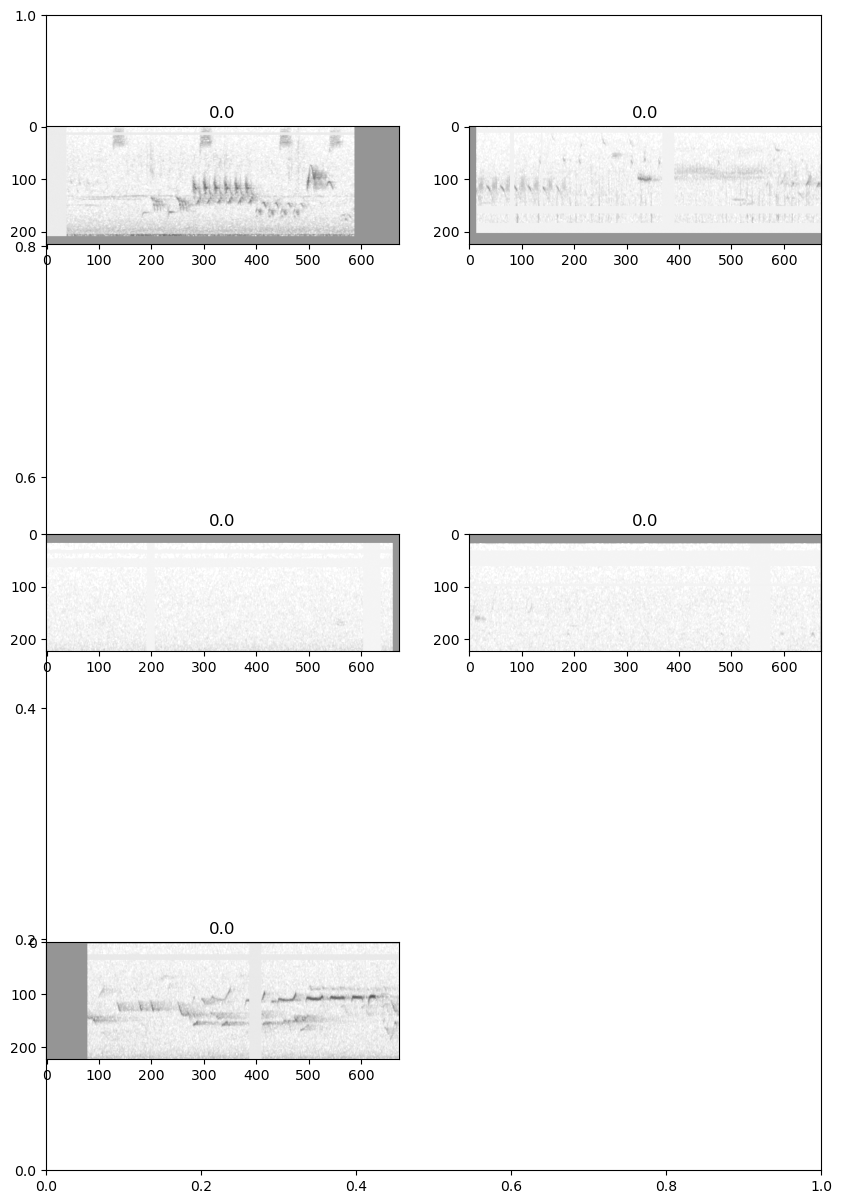

In [9]:
train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(df_train, target_species = "OSFL", download_n=0)

In [10]:
train_df = train_dataset.label_df
valid_df = valid_dataset.label_df

In [11]:
train_df.target_presence.value_counts(), valid_df.target_presence.value_counts()

(target_presence
 0.0    42393
 1.0     4106
 Name: count, dtype: int64,
 target_presence
 0.0    12635
 1.0     1148
 Name: count, dtype: int64)

In [12]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that all classes have 800 samples
balanced_train_df = resample(train_df,n_samples_per_class=500,random_state=0)

In [13]:
balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 0.0    500
 1.0    500
 Name: count, dtype: int64,
 1000)

In [14]:
def last_clip(df, idx):
    '''
    show last clip from a recording in dataframe with multi index.
    '''
    path = df.index[idx][0]
    return df.loc[path].iloc[-1].name[1]

def show_sample(df, idx):
    print(f"Present label: {df.iloc[idx].target_presence}")
    print(f"Last clip: {last_clip(df, idx)}")
    show_sample_from_df(df, idx)
    idx += 1
    return idx

In [15]:
idx=0

In [16]:
shuffled_balanced_train_df = balanced_train_df.sample(frac = 1)

Present label: 0.0
Last clip: 3.0
../../data/raw/recordings/OSFL/recording-556707.flac 1.5 4.5


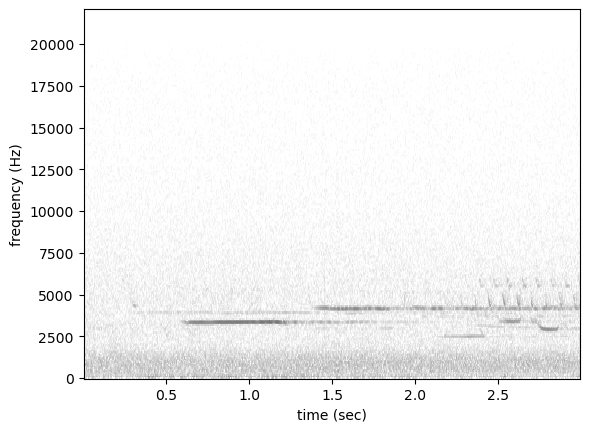

In [17]:
show_sample(shuffled_balanced_train_df, idx)
idx += 1

In [18]:
balanced_train_df.columns

Index(['target_absence', 'target_presence'], dtype='object')

In [19]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(balanced_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
model.single_target = True


In [20]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

In [21]:
class_list

['target_absence', 'target_presence']

In [22]:
def show_sample_from_df(present=True, df = balanced_train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


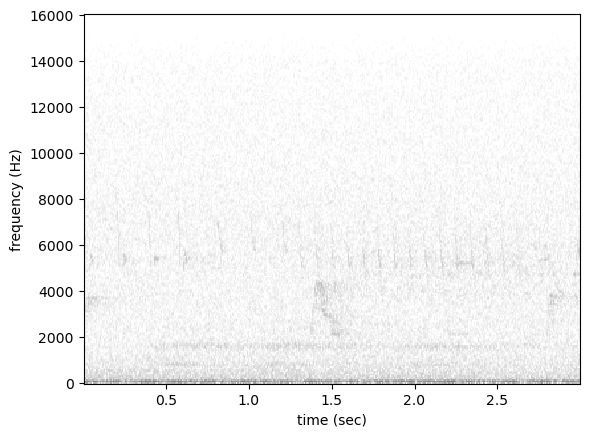

In [23]:
show_sample_from_df(present=True)

In [24]:
print(f'model.device is: {model.device}')

model.device is: mps


In [25]:
%set_env WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"

env: WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"


In [26]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    config={
    "epochs":8,
    "log_histograms":False,
    }
)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "1.15.1-mjg-osfl-revisit-opso-training-cycle".
wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [27]:
balanced_train_df

,,,target_absence,target_presence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-291727.mp3,130.5,133.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-292735.mp3,25.5,28.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-390114.flac,40.5,43.5,1.0,0.0
../../data/raw/recordings/OSFL/recording-100033.mp3,6.0,9.0,1.0,0.0
../../data/raw/recordings/OSFL/recording-291854.mp3,6.0,9.0,1.0,0.0
...,...,...,...,...
../../data/raw/recordings/OSFL/recording-553394.flac,7.5,10.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-292013.mp3,0.0,3.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-556820.flac,54.0,57.0,0.0,1.0


In [28]:
model.train(
    shuffled_balanced_train_df,
    valid_df,
    epochs = 8,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0 [batch 0/16, 0.00%] 
	DistLoss: 0.708
Metrics:
Epoch: 0 [batch 10/16, 62.50%] 
	DistLoss: 0.712
Metrics:
Metrics:

Validation.


  0%|          | 0/216 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 1


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1 [batch 0/16, 0.00%] 
	DistLoss: 0.673
Metrics:
Epoch: 1 [batch 10/16, 62.50%] 
	DistLoss: 0.702
Metrics:
Metrics:

Validation.


  0%|          | 0/216 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 2


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2 [batch 0/16, 0.00%] 
	DistLoss: 0.657
Metrics:
Epoch: 2 [batch 10/16, 62.50%] 
	DistLoss: 0.683
Metrics:
Metrics:

Validation.


  0%|          | 0/216 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 3


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3 [batch 0/16, 0.00%] 
	DistLoss: 0.642
Metrics:
Epoch: 3 [batch 10/16, 62.50%] 
	DistLoss: 0.605
Metrics:
Metrics:

Validation.


  0%|          | 0/216 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 4


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4 [batch 0/16, 0.00%] 
	DistLoss: 0.613
Metrics:
Epoch: 4 [batch 10/16, 62.50%] 
	DistLoss: 0.571
Metrics:
Metrics:

Validation.


  0%|          | 0/216 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 5


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5 [batch 0/16, 0.00%] 
	DistLoss: 0.446
Metrics:
Epoch: 5 [batch 10/16, 62.50%] 
	DistLoss: 0.441
Metrics:
Metrics:

Validation.


  0%|          | 0/216 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 6


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6 [batch 0/16, 0.00%] 
	DistLoss: 0.592
Metrics:
Epoch: 6 [batch 10/16, 62.50%] 
	DistLoss: 0.493
Metrics:
Metrics:

Validation.


  0%|          | 0/216 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Training Epoch 7


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7 [batch 0/16, 0.00%] 
	DistLoss: 0.383
Metrics:
Epoch: 7 [batch 10/16, 62.50%] 
	DistLoss: 0.467
Metrics:
Metrics:

Validation.


  0%|          | 0/216 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Best Model Appears at Epoch 7 with Validation score 0.649.


In [29]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▂▃▄▅▆▇█
loss,██▇▅▄▁▂▁
epoch,7
loss,0.45802


In [42]:
model.valid_metrics

{0: {'confusion_matrix': array([[   42, 12593],
         [    4,  1144]]),
  'precision': 0.08327873625973647,
  'recall': 0.9965156794425087,
  'f1': 0.1537117903930131,
  'jaccard': 0.04328877077999552,
  'hamming_loss': 0.9139519698178916},
 1: {'confusion_matrix': array([[  416, 12219],
         [   18,  1130]]),
  'precision': 0.08465053562064574,
  'recall': 0.9843205574912892,
  'f1': 0.15589432296337172,
  'jaccard': 0.05870706183160341,
  'hamming_loss': 0.887832837553508},
 2: {'confusion_matrix': array([[5074, 7561],
         [ 185,  963]]),
  'precision': 0.1129751290473956,
  'recall': 0.8388501742160279,
  'f1': 0.19913151364764267,
  'jaccard': 0.25318154923923447,
  'hamming_loss': 0.5619966625553218},
 3: {'confusion_matrix': array([[12275,   360],
         [  742,   406]]),
  'precision': 0.5300261096605744,
  'recall': 0.35365853658536583,
  'f1': 0.42424242424242425,
  'jaccard': 0.5934252822007924,
  'hamming_loss': 0.07995356598708554},
 4: {'confusion_matrix': ar

# Too good to be true?
Load the results into notebook 1.21 for sanity check

In [44]:
# save the splits
pd.to_pickle(valid_df, data_path / "interim" / "valid_set" / "valid_df_swap.pkl")
pd.to_pickle(train_df, data_path / "interim" / "train_set" / "train_df_swap.pkl")



In [45]:
# save the model too
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / "osfl_model_28022024_swap")

In [46]:
best_model.valid_metrics

{0: {'confusion_matrix': array([[   42, 12593],
         [    4,  1144]]),
  'precision': 0.08327873625973647,
  'recall': 0.9965156794425087,
  'f1': 0.1537117903930131,
  'jaccard': 0.04328877077999552,
  'hamming_loss': 0.9139519698178916},
 1: {'confusion_matrix': array([[  416, 12219],
         [   18,  1130]]),
  'precision': 0.08465053562064574,
  'recall': 0.9843205574912892,
  'f1': 0.15589432296337172,
  'jaccard': 0.05870706183160341,
  'hamming_loss': 0.887832837553508},
 2: {'confusion_matrix': array([[5074, 7561],
         [ 185,  963]]),
  'precision': 0.1129751290473956,
  'recall': 0.8388501742160279,
  'f1': 0.19913151364764267,
  'jaccard': 0.25318154923923447,
  'hamming_loss': 0.5619966625553218},
 3: {'confusion_matrix': array([[12275,   360],
         [  742,   406]]),
  'precision': 0.5300261096605744,
  'recall': 0.35365853658536583,
  'f1': 0.42424242424242425,
  'jaccard': 0.5934252822007924,
  'hamming_loss': 0.07995356598708554},
 4: {'confusion_matrix': ar

The resnet18 model didn't show convergence. 
The resnet 34 model showed convergence, and the ordering of the labels in the source dataframe was making large differences to the reported metrics. If the absent label is at the 0th index and the present label is at index 1, the metrics look great, but swapping the order of the columns affects the scores. 

Intuitively this shouldn't matter - the classes are still being matched up to the same labels. 
I think there are two things happening here:
1. When the metrics are calculated, opso or sklearn expects that the positive class will be at the 1st index and the negative class will be at the 0th index. This makes sense - since that would make the result of argmax equal to 1 for the present class and 0 for the absent class. 

This still leaves the question of why the metrics would look better when considering the absent class as the positive class rather than the other way around. There are a few things going on here:
- In the training set, there are the same number of present clips as absent clips but in the validation set there are far more absent clips than present clips. 
- When we considered the absent class to be the target class, the scores were higher. This might suggest that the model is better at predicting absent than it is at predicting presence. I could test this theory by measuring the metrics only on the absent class, then only on the present class.

Why could this be?
- It might be that there are more incorrectly labelled present clips than there are absent clips.  If noisy present labels are the issue, then that's a relatively quick fix. 

I can now check the effect of cleaning the dataset. 

In [34]:
model.loss_hist

{0: 0.70797265,
 1: 0.70844746,
 2: 0.67946094,
 3: 0.6024191,
 4: 0.54979974,
 5: 0.4429311,
 6: 0.48945794,
 7: 0.4580235}

In [35]:
# Check that the ordering of the classes in train and valid datasets matches the classes of the model 
train_dataset.class_counts()
valid_dataset.class_counts()

(Index(['target_absence', 'target_presence'], dtype='object'),
 array([12635.,  1148.]))

In [36]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

# Make predictions on the validation set
http://opensoundscape.org/en/latest/tutorials/predict_with_cnn.html

In [37]:
from opensoundscape.ml.cnn import load_model
# Other utilities and packages
import torch
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob
import subprocess

In [38]:


#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [39]:
torch.hub.list('kitzeslab/bioacoustics-model-zoo')

Using cache found in /Users/mikeg/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


['BirdNET', 'Perch', 'SeparationModel', 'YAMNet', 'rana_sierrae_cnn']

In [40]:
valid_dataset.label_df

target_absence  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-4503.mp3  0.0        3.0                  1.0   
                                                   1.5        4.5                  1.0   
                                                   3.0        6.0                  1.0   
                                                   4.5        7.5                  1.0   
                                                   6.0        9.0                  1.0   
...                                                                                ...   
../../data/raw/recordings/OSFL/recording-826374... 15.0       18.0                 0.0   
../../data/raw/recordings/OSFL/recording-826375... 0.0        3.0                  0.0   
                                                   1.5        4.5                  0.0   
                                                   46.5       49.5                 0.0   
                                                   48.0       51.0                 0.0   

                                                                        target_presence  
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-4503.mp3  0.0        3.0                   0.0  
                                                   1.5        4.5                   0.0  
                                                   3.0        6.0                   0.0  
                                                   4.5        7.5                   0.0  
                                                   6.0        9.0                   0.0  
...                                                                                 ...  
../../data/raw/recordings/OSFL/recording-826374... 15.0       18.0                  1.0  
../../data/raw/recordings/OSFL/recording-826375... 0.0        3.0                   1.0  
                                                   1.5        4.5                   1.0  
                                                   46.5       49.5                  1.0  
                                                   48.0       51.0                  1.0  

[13783 rows x 2 columns]

In [41]:
sample_preds = model.predict(valid_dataset.label_df).sample(frac=0.1)

  0%|          | 0/13783 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute '_log'

The model isn't changing its prdictions at all with different inputs. 

In [ ]:
# model.generate_samples(sample)